# HRV ANALYSIS

In [4]:
# system imports
import os
cwd = os.getcwd()

# data science
import pandas as pd; print('pandas', pd.__version__)
import numpy as np; print('numpy', np.__version__)
import matplotlib; print('matplotlib', matplotlib.__version__)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns; print('seaborn', sns.__version__)
import math
from scipy import stats
import datetime as dt
from datetime import timedelta
from datetime import datetime, timedelta


# style settings
sns.set(style='whitegrid', rc={'axes.facecolor':'#EFF2F7'})
plt.rcParams['figure.figsize'] = [15,7] # neurokit plots
red = '\033[91m'
green = '\033[92m'
blue = '\033[94m'
bold = '\033[1m'
italics = '\033[3m'
underline = '\033[4m'
end = '\033[0m'

# signal processing
import hrvanalysis; print('hrv-analysis', hrvanalysis.__version__)
import pyhrv; print('pyHRV', pyhrv.__version__)
import neurokit2; print('neurokit', neurokit2.__version__)
from neurokit2.hrv.hrv_utils import _hrv_format_input

# misc
import warnings

pandas 1.1.3
numpy 1.19.2
matplotlib 3.6.2
seaborn 0.11.0
hrv-analysis 1.0.3
pyHRV 0.4.1


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


neurokit 0.2.2


# <span style='background :blue' > To be Filled by Data Analyst </span>

In [5]:
sampling_freq = 60 # sample freqency for RR interval
duration_analysis_general = 5
prefix_pre = 'Pre'
prefix_during = 'During'
prefix_post = 'Post'
first_event = 'Reference'

path_file = cwd + '/SOA_AC_2022/Serial 4/' # directory where the files are stored
date = '_17May_Day5'
event = 'CQB7' # prefix for the saved results_HRV document 
first_participant = 'P401'

participant = 'P419' # participant number
start_time_str = '19:47:17' # time where to start the analysis
stop_time_str = '19:52:02' # not needed for reference


## Specify reference/baseline NN-interval
# file = 
# nni_total = pd.read_csv(path_file + file)
# reference_nni = nni_total[2000:3000]

# Data Integration

In [6]:
# Print all files to merge
file_list = os.listdir(path_file + '/for_analysis')
# print(f'\n{underline}List of all BioHarness files in the directory:{end} ', *file_list, sep='\n')
print('')

# Find all files belonging to the same participant
files_participant = []

for file in file_list:
    if file.startswith(participant + date):
        files_participant.append(file)
        
print(f'{underline}{blue}{bold}Files to be merged from participant_{participant}:{end}', *files_participant, sep='\n')
print('')

# Merge all BioHarness files from the same participant 
merged_df = pd.concat([pd.read_csv(path_file + 'for_analysis/' + file) for file in files_participant], ignore_index=False, axis=1)

# Rename the two 'Time' columns
cols = []
count = 1
for column in merged_df.columns:
    if column == 'Time':
        cols.append(f'Time_{count}')
        count+=1
        continue
    cols.append(column)
merged_df.columns = cols

# Determine which column that is full of null values and remove it
merged_df = merged_df.drop(merged_df.columns[merged_df.isnull().sum() == len(merged_df)], axis=1)

# Rename the 'Time' column
time_col = [col for col in merged_df if col.startswith('Time')][0]
merged_df = merged_df.rename(columns={time_col:"Time"})

# Convert 'Time' to DateTime format
merged_df['DateTime'] = merged_df['Time'].apply(pd.to_datetime).dt.ceil('s') # remove ms
merged_df['Date'] = merged_df['DateTime'].dt.date
merged_df['Time'] = merged_df['DateTime'].dt.time

# Only keep the features of interest
merged_df = merged_df[['HR','HRConfidence','RtoR','Date','Time','DateTime']]


Files to be merged from participant_P419:
P419_17May_Day5_2022_05_17-17_24_19_RR.csv
P419_17May_Day5_2022_05_17-17_24_19_Summary.csv



# Raw RR signal

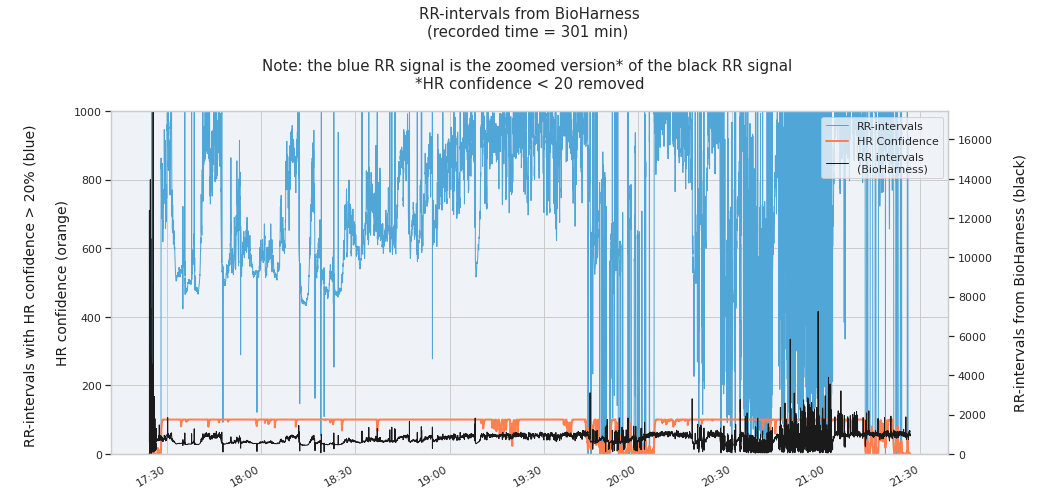

In [7]:
# Replace signal with HR confidence > 20% by 0
merged_df['RtoR_gt20'] = np.where((merged_df.HRConfidence > 20), merged_df['RtoR'], 0)

# Find the index where the first RR-interval is > 0
first_index = [i for i in range(len(merged_df.RtoR_gt20)) if merged_df.RtoR_gt20[i] > 0][0] # show only the first index

# Total duration of the recorded signal in minutes (>20% HRConf)
total_duration = (merged_df.RtoR_gt20.index.stop - merged_df.RtoR_gt20.index.start) / sampling_freq 

# Plot 
rr_min = merged_df.RtoR.min() 
rr_max = merged_df.RtoR.max() 

fig, ax1 = plt.subplots(figsize=(15,7))
plt.title("RR-intervals from BioHarness\n(recorded time = %.0f min) \n\nNote: the blue RR signal is the zoomed version* of the black RR signal \n*HR confidence < 20 removed" \
          % total_duration, fontsize=15, y=1.05)

ax2 = ax1.twinx() # mirror ax1
ax1.set_ylim(0, 1000)
ax2.set_ylim(0, rr_max)
ax1.set_ylabel(f'\nRR-intervals with HR confidence > 20% (blue) \n\nHR confidence (orange)', color='k', fontsize=14)
ax2.set_ylabel('\nRR-intervals from BioHarness (black)\n', color='k', fontsize=14)


plot_1 = ax1.plot(merged_df.DateTime, merged_df.RtoR_gt20, label=f'RR-intervals', color='#51A6D8', linewidth=1) # raw RtoR > 20
plot_2 = ax1.plot(merged_df.DateTime, merged_df.HRConfidence, label=f'HR Confidence', color='coral', linewidth=2) # HR confidence
plot_3 = ax2.plot(merged_df.DateTime, merged_df.RtoR, label=f'RR intervals \n(BioHarness)', color='k', linewidth=1) # raw RtoR


# Change X-axis to Time format
plt.gcf().autofmt_xdate()
time_format = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(time_format)

plt.grid(False)

# Add legends
plot_list = plot_1 + plot_2 + plot_3
labels = [label.get_label() for label in plot_list]
plt.legend(plot_list, labels, loc='best');

# Cleaning - entire signal

Pre-processing for the outliers and ectopic beats. <br>
Interpolate outliers and ectopic beats with linear interpolation

In [8]:
# Replace RR-interval outlier by nan
rr_no_outliers = hrvanalysis.remove_outliers(rr_intervals=merged_df.RtoR_gt20, low_rri=300, high_rri=2000, verbose=False)

# Replace nan values with linear interpolation
rr_interpolated = hrvanalysis.interpolate_nan_values(rr_intervals=rr_no_outliers, interpolation_method="linear")

# Remove ectopic beats from signal (method: malik, karlsson, kamath, acar)
nni_no_ectopic = hrvanalysis.remove_ectopic_beats(rr_intervals=rr_interpolated, method="malik", custom_removing_rule=10, verbose=True)

# Replace ectopic beats (nan values) with linear interpolation
nni_interpolated = hrvanalysis.interpolate_nan_values(rr_intervals=nni_no_ectopic, interpolation_method="linear")

# Determine cleaned NN-intervals for the entire signal (>20%)
nni_total = pd.Series(nni_interpolated, name='nni_total')

681 ectopic beat(s) have been deleted with malik rule.


# <span style='background :green' > Analysis --> PRE </span>

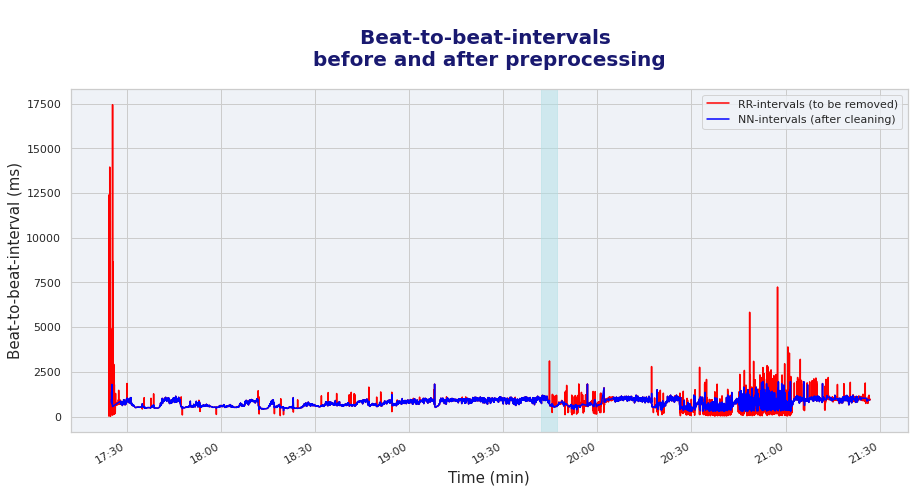

In [9]:
# ----------------- GENEREAL SETTINGS -----------------
delta_pd_pre = pd.to_timedelta(duration_analysis_general, unit='m')
start_time_pd = pd.to_datetime(start_time_str, format='%H:%M:%S')
start_time_pd_pre = (start_time_pd - delta_pd_pre).round(freq='S')
stop_time_pd_pre = start_time_pd
start_time_pre = start_time_pd_pre.time()
stop_time_pre = stop_time_pd_pre.time()
start_index_pre = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == start_time_pre][0]
stop_index_pre = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == stop_time_pre][0]



# ----------------- PLOT RR/NN INTERVALS -----------------

# Plot raw (RRi) and cleaned (NNi) signals
fig, ax = plt.subplots(figsize=(15, 7))

# ax.axvspan(start_index, start_time, 0, 1, alpha=0.5, color='powderblue', label="HRV analysis between %.0f and %.0f min" %(start_time, start_time))
plt.title("\nBeat-to-beat-intervals \nbefore and after preprocessing", fontsize=20, weight='bold', ha='center', y=1.05, color='midnightblue')         
plt.xlabel("Time (min)", fontsize=15)
plt.ylabel("Beat-to-beat-interval (ms)", fontsize=15)

plt.plot(merged_df.DateTime, merged_df.RtoR, color="red", label="RR-intervals (to be removed)") # raw RR
plt.plot(merged_df.DateTime, nni_total, color="blue", label="NN-intervals (after cleaning)") # cleaned NN

# Change X-axis to Time format
plt.gcf().autofmt_xdate()
time_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_format)

# Shaded area (section selected for the current analysis)
year = merged_df['DateTime'].dt.year[start_index_pre].astype(int)
month = merged_df['DateTime'].dt.month[start_index_pre].astype(int)
day = merged_df['DateTime'].dt.day[start_index_pre].astype(int)
start_hour = merged_df['DateTime'].dt.hour[start_index_pre].astype(int)
start_minute = merged_df['DateTime'].dt.minute[start_index_pre].astype(int)
stop_hour = merged_df['DateTime'].dt.hour[stop_index_pre].astype(int)
stop_minute = merged_df['DateTime'].dt.minute[stop_index_pre].astype(int)

ax.axvspan(mdates.date2num(datetime(year,month,day,start_hour,start_minute)), mdates.date2num(datetime(year,month,day,stop_hour,stop_minute)), 0, 1, alpha=0.5, color='powderblue')

# Add legend
plt.legend(loc='best');

## <span style='background :blue' > Cleaning - selection only</span>
Pre-processing for the outliers and ectopic beats. <br>
Interpolate outliers and ectopic beats with linear interpolation <br>
Determine % correction of the chosen HRV analysis section

In [11]:
# Replace RR-interval (>20%) outlier by nan (for the section selected)
rr_no_outliers_pre = hrvanalysis.remove_outliers(rr_intervals=merged_df.RtoR_gt20[start_index_pre:stop_index_pre], low_rri=300, high_rri=2000, verbose=True)

# Replace nan values with linear interpolation
rr_interpolated_pre = hrvanalysis.interpolate_nan_values(rr_intervals=rr_no_outliers_pre, interpolation_method="linear")

# Remove ectopic beats from signal (method: malik, karlsson, kamath, acar)
nni_no_ectopic_pre = hrvanalysis.remove_ectopic_beats(rr_intervals=rr_interpolated_pre, method="malik", custom_removing_rule=10, verbose=True)

# Replace ectopic beats (nan values) with linear interpolation
nni_interpolated_pre = hrvanalysis.interpolate_nan_values(rr_intervals=nni_no_ectopic_pre, interpolation_method="linear")

# Convert NN to Series with same index as rr_raw
new_index_analysis_pre = list(np.arange(start=merged_df.RtoR_gt20[start_index_pre:stop_index_pre].index.start, \
                                     stop=merged_df.RtoR_gt20[start_index_pre:stop_index_pre].index.stop, step=1)) 

# Determine cleaned NN-intervals (>20%)
nni_analysis_pre = pd.Series(nni_interpolated_pre, index=new_index_analysis_pre, name='nni')

# Calculate % corrected
n_outlier_pre = sum(math.isnan(x) for x in rr_no_outliers_pre)
n_ectopic_pre = sum(math.isnan(x) for x in nni_no_ectopic_pre)
corrected_pre = (n_outlier_pre+n_ectopic_pre)/(2*len(nni_analysis_pre))*100

print(f"""
{underline}{bold}Findings - Analysis Section{end}
{n_outlier_pre} outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
{n_ectopic_pre} ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

{underline}{bold}{blue}Discussion - Analysis Section{end}
A total of {n_outlier_pre+n_ectopic_pre} beat(s) were interpolated using the linear method which is equivalent to {blue}{red}{round(corrected_pre,2)}%{end} of all beats selected for the analysis.
The recommended percentage of artifact correction is less than 5% so this section of the signal ({bold}nni_analysis{end}) can be used to calculate HRV indices.
""")

24 outlier(s) have been deleted.
The outlier(s) value(s) are : [0, 0, 0, 0, 0, 0, 0, 0, 0, 3110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 233]
5 ectopic beat(s) have been deleted with malik rule.

Findings - Analysis Section
24 outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
5 ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

Discussion - Analysis Section
A total of 29 beat(s) were interpolated using the linear method which is equivalent to 4.83% of all beats selected for the analysis.
The recommended percentage of artifact correction is less than 5% so this section of the signal (nni_analysis) can be used to calculate HRV indices.



/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/tools.py:375: UserWarning: Interval limits out of boundaries. Interval set to: [0, 235.41675]
  interval = pyhrv.utils.check_interval(interval, limits=[0, t[-1]], default=[0, 10])


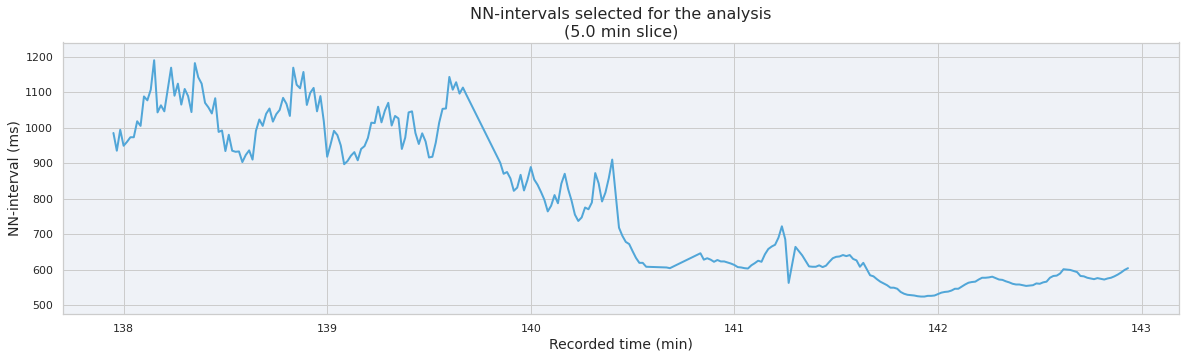

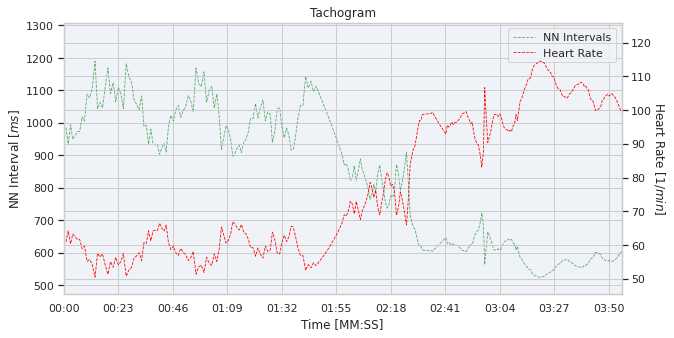

In [12]:
################## Plot section selected for the analysis ########################

# Determine if any Nan values and if so, remove them for the analysis
if nni_analysis_pre.isnull().values.any() == True:
    loc = nni_analysis_pre.index.get_loc(nni_analysis_pre.first_valid_index()) # where the first value is located
    nni_analysis_pre = nni_analysis_pre[loc:] # keep only real values
    print(f'\n nni_analysis had {loc} NaN values that were removed for further analysis \n nni_analysis now has only {len(nni_analysis_pre)} values', end='\n\n')
    
else:
    pass


# Determine NN interval for the analysis
nni_pre = nni_analysis_pre

# Plot NN intervals selected for analysis
nni_min_pre = nni_pre.min() - 50
nni_max_pre = nni_pre.max() + 50
plt.figure(figsize=(20,5))
plt.title("NN-intervals selected for the analysis\n(%.1f min slice)" % round(len(nni_pre)/60,1), fontsize=16)
plt.xlabel('Recorded time (min)', fontsize=14)
plt.ylabel('NN-interval (ms)', fontsize=14)
plt.ylim(nni_min_pre, nni_max_pre)
plt.grid(True)

plt.plot(nni_pre.index/sampling_freq, nni_pre, color="#51A6D8", linewidth=2);



########################### TACHOGRAM #############################
# Plot NNi and HR on same graph
pyhrv.tools.tachogram(nni=nni_pre, sampling_rate=sampling_freq, hr=True, interval=[0,len(nni_pre)], title=None, figsize=(10,5));


## <span style='background :blue' > HRV Analysis </span>

<span style='color:yellow'> 
    TIME DOMAIN 
</span>

In [13]:
# Plot NN distribution
pyhrv.time_domain.tinn(nni=nni_pre, binsize=50, plot=True, show=True, figsize=(6,6), legend=True);

# Compute Time Domain parameters using the NNI-series  
print(f"\n{bold}{red}Time domain indices using NN-intervals:{end}")
results_time_domain_pre = pyhrv.time_domain.time_domain(nni=nni_pre, plot=False)

params = ['hr_mean', 'hr_std', 'hr_min', 'hr_max', 'nni_mean', 'sdnn', 'rmssd']
for i in params:
    print(f'- {i} = {results_time_domain_pre[i].round(1)}')

/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '



Time domain indices using NN-intervals:


/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")


- hr_mean = 81.8
- hr_std = 20.7
- hr_min = 50.4
- hr_max = 114.5
- nni_mean = 784.7
- sdnn = 207.1
- rmssd = 33.5


### Stress Index - try windorizing the outliers first - TO DO

In [14]:
# Plot histogram
nni_min_pre = nni_pre.min()
nni_max_pre = nni_pre.max()
binsize = 50 # 50ms bin width
bins = np.arange(round((nni_min_pre-50)/50)*50, nni_max_pre + binsize, binsize)

plt.figure(figsize=(6,6))
counts, edges, bars = plt.hist(x=nni_pre, bins=bins, facecolor='b', orientation='vertical', histtype='bar', stacked=False)
plt.bar_label(bars) # counts on top
plt.title('NNi Histogram (Pre)')
plt.xlabel('NNi (ms)')
plt.ylabel('Number of NNi')
plt.xlim(nni_min_pre-100, nni_max_pre+100);


############################### Baevsky’s Stress Index

# AMo was calculated, using a 50 ms bin width, as the number of the RR intervals in the bin containing the Mo, expressed as a percentage of the total number of intervals measured.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8275990/
# https://pdfs.semanticscholar.org/f9aa/e61bb8301565683a63592ed57e47765b6671.pdf?_ga=2.243993989.1087171154.1670987388-1864625205.1670987388
# https://www.academia.edu/35296847/Methodical_recommendations_USE_KARDiVAR_SYSTEM_FOR_DETERMINATION_OF_THE_STRESS_LEVEL_AND_ESTIMATION_OF_THE_BODY_ADAPTABILITY_Standards_of_measurements_and_physiological_interpretation_Moscow_Prague_2008
Mo_pre = stats.mode(nni_pre)[0][0]/1000 # sec
MxDMn_pre = (nni_max_pre-nni_min_pre)/1000 # sec
N_pre = len(nni_pre)
AMo_pre = counts.max()/N_pre

SI_pre = AMo_pre*100 / (2*Mo_pre*MxDMn_pre)
SI_2_pre = AMo_pre*100 / (2*Mo_pre*3.92*results_time_domain_pre['sdnn']/1000) # https://arxiv.org/pdf/2210.01791.pdf
# this corresponds to the range spanning 95% of interval samples within the set (i.e. 1.96 standard deviations in either direction of the mean). 
# This was experimentally observed to provide readings more robust to noise that arises from the misclassification of a single inter-beat interval
print('Baevsky’s Stress Index:', round(SI_2_pre))

Baevsky’s Stress Index: 22


<span style='color:yellow'> 
    FREQUENCY DOMAIN 
</span>

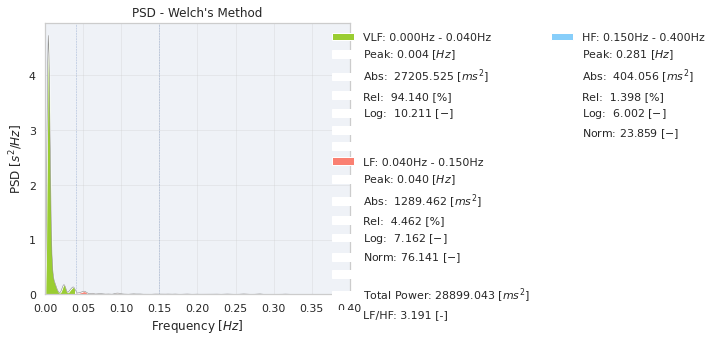


Frequency domain indice using NN-intervals:
- LF/HF ratio = 3.19


In [15]:
# Plot Frequency graph
results_welch_pre = pyhrv.frequency_domain.welch_psd(nni=nni_pre, window='hamming', show_param=True, legend=True);

# Print Frequency domain indice
print(f'\n{bold}{red}Frequency domain indice using NN-intervals:{end}\n- LF/HF ratio =', round(results_welch_pre['fft_ratio'],2))

<span style='color:yellow'> 
    NONLINEAR DOMAIN 
</span>


Poincare incides using NN-intervals (pyHRV):
- SD1 = 23.6
- SD2 = 291.5
- SD2/SD1 = 12.3

Poincare incides using NN-intervals (neurokit2):
- SD1 = 25.2
- SD2 = 292.0



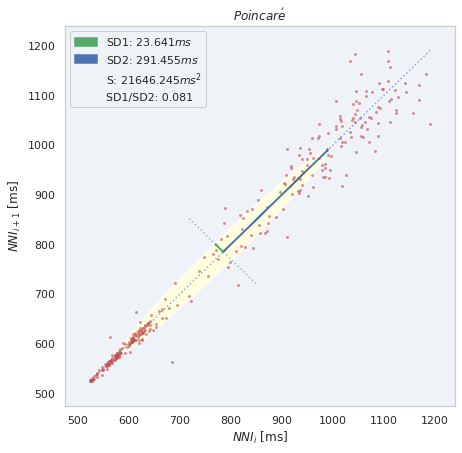

In [16]:
# Plot Poincare graph -- pyHRV
results_poincare_pre = pyhrv.nonlinear.poincare(nni=nni_pre, show=False, figsize=(7,7), legend=True, ellipse=True, marker='o');

# Plot Poincare graph -- neurokit2
rpeaks_pre = neurokit2.intervals_to_peaks(intervals=nni_pre, sampling_rate=sampling_freq) #convert RR to Rpeaks
hrv_indices_pre = neurokit2.hrv_nonlinear(rpeaks_pre, sampling_rate=sampling_freq, show=False)


# Print Poincare indices
print(f"\n{bold}{red}Poincare incides using NN-intervals (pyHRV):{end}")  
for i, a in enumerate(results_poincare_pre[1:-1]):
    param = ['SD1','SD2','SD2/SD1']  
    print(f'- {param[i]} = {round(a,1)}')

print(f"\n{bold}{red}Poincare incides using NN-intervals (neurokit2):{end}") 
print('- SD1 =', hrv_indices_pre['HRV_SD1'][0].round(1))
print('- SD2 =', hrv_indices_pre['HRV_SD2'][0].round(1))
print('')

<span style='color:yellow'> 
    RADAR CHART
</span>

In [18]:
'''
# -------------------- REFERENCE INDICES --------------------

# Specify reference/baseline NN-interval
reference_nni = reference_nni


reference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)
for k, v in reference_time_domain.items():
    exec('ref_%s = %.1f' % (k,v)) # create new variable
    
reference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)
for k, v in reference_freq_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
reference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)
for k, v in reference_poincare_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
# -------------------- COMPARISON INDICES --------------------
comparison_time_domain = hrvanalysis.get_time_domain_features(nni)
for k, v in comparison_time_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)
for k, v in comparison_freq_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_poincare_domain = hrvanalysis.get_poincare_plot_features(nni)
for k, v in comparison_poincare_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
    
# -------------------- RELATIVE DIFFERENCE --------------------
ref_mean_nni_pc = ref_mean_nni / ref_mean_nni * 100
ref_sdnn_pc = ref_sdnn / ref_sdnn * 100
ref_rmssd_pc = ref_rmssd / ref_rmssd * 100
ref_sd1_pc = ref_sd1 / ref_sd1 * 100
ref_lf_hf_ratio_pc = ref_lf_hf_ratio / ref_lf_hf_ratio * 100

comp_mean_nni_pc = comp_mean_nni / ref_mean_nni * 100
comp_sdnn_pc = comp_sdnn / ref_sdnn * 100
comp_rmssd_pc = comp_rmssd / ref_rmssd * 100
comp_sd1_pc = comp_sd1 / ref_sd1 * 100
comp_lf_hf_ratio_pc = comp_lf_hf_ratio / ref_lf_hf_ratio * 100


# -------------------- GENERAL SETTINGS --------------------
# Determine indices to plot
params = ['nni_mean', 'SDNN', 'rMSSD', 'SD1', 'HF/LF ratio']

reference_nni = [ref_mean_nni_pc, ref_sdnn_pc, ref_rmssd_pc, ref_sd1_pc, ref_lf_hf_ratio_pc]
comparison_nni = [comp_mean_nni_pc, comp_sdnn_pc, comp_rmssd_pc, comp_sd1_pc, comp_lf_hf_ratio_pc]

reference_nni = [*reference_nni, reference_nni[0]]
comparison_nni = [*comparison_nni, comparison_nni[0]]

# Number of indices to plot
num_vars = len(params)


# -------------------- PLOT RADAR CHART --------------------
# Split the circle into even parts
label_loc = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()

# Complete the circle and append the start value to the end
label_loc += label_loc[:1]

# Settings
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Plot reference and comparison data
ax.plot(label_loc, reference_nni, color='turquoise', linewidth=1.5)
ax.plot(label_loc, comparison_nni, color='coral', linewidth=1.5)

# Add colour area
ax.fill(label_loc, reference_nni, color='turquoise', alpha=0.25, label='reference_nni')
ax.fill(label_loc, comparison_nni, color='coral', alpha=0.25, label='comparison_nni')

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Draw axis lines for each label location and indices
ax.set_thetagrids(np.degrees(label_loc[:-1]), params)

# Go through indices and adjust alignment based on where it is in the circle
for param, angle in zip(ax.get_xticklabels(), label_loc):
    if angle in (0, np.pi):
        param.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        param.set_horizontalalignment('left')
    else:
        param.set_horizontalalignment('right')

# Set position of y-labels (0-100) to be in the middle of the first two axes
ax.set_rlabel_position(180/num_vars)

# Make the y-axis (0-100) labels smaller
ax.tick_params(axis='y', labelsize=8)

# Change colors 
ax.tick_params(colors='#222222') #tick labels
ax.grid(color='#AAAAAA') #circular gridlines
ax.spines['polar'].set_color('#222222') #outermost gridline (the spine)
ax.set_facecolor('#FAFAFA') #background color inside the circle

# Add title
ax.set_title('\nHRV parameter Radar Chart \n Reference NNi vs. Comparison NNi \n $\it{%}$ Chart values are in %, Reference NNi parameters = 100%', size=15, y=1.15)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1));


# Save figure with participant number
plt.savefig(fname=path_file + 'analyzed//RadarChart_' + participant, format='jpeg', dpi=100, orientation='portrait', papertype='letter', transparent=True, bbox_inches='tight')


# -------------------- PRINT RESULTS --------------------
print(f"""{blue} {bold} {underline}
Parameters\tReference vs. Comparison\tDifference(%){end}
nni_mean \t{round(ref_mean_nni,2)}ms\tvs. {round(comp_mean_nni,2)}ms \t\t {round((comp_mean_nni_pc-ref_mean_nni_pc),1)} %
SDNN \t\t{round(ref_sdnn,2)}ms\tvs. {round(comp_sdnn,2)}ms \t\t {round((comp_sdnn_pc-ref_sdnn_pc),1)} %
rSSMD \t\t{round(ref_rmssd,2)}ms\tvs. {round(comp_rmssd,2)}ms \t\t {round((comp_rmssd_pc-ref_rmssd_pc),1)} %
SD1 \t\t{round(ref_sd1,2)}\tvs. {round(comp_sd1,2)} \t\t {round((comp_sd1_pc-ref_sd1_pc),1)} %
HF/LF ratio \t{round(ref_lf_hf_ratio,2)}\tvs. {round(comp_lf_hf_ratio,2)} \t\t {round((comp_lf_hf_ratio_pc-ref_lf_hf_ratio_pc),1)} %
""")

'''

'\n# -------------------- REFERENCE INDICES --------------------\n\n# Specify reference/baseline NN-interval\nreference_nni = reference_nni\n\n\nreference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)\nfor k, v in reference_time_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v)) # create new variable\n    \nreference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)\nfor k, v in reference_freq_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \nreference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)\nfor k, v in reference_poincare_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \n# -------------------- COMPARISON INDICES --------------------\ncomparison_time_domain = hrvanalysis.get_time_domain_features(nni)\nfor k, v in comparison_time_domain.items():\n    exec(\'comp_%s = %.1f\' % (k,v))\n    \ncomparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)\nfor k, v in comparison_freq_doma

## <span style='background :blue' > Report - PRE </span>

In [20]:
# Note: only create a DF if the Event is not Reference (because we don't need Pre- for Reference)
if first_event == event:
    pass
else:

    results_pre = []
    metrics_pre = {}


    metrics_pre['mean_HR (bpm)'] = round(results_time_domain_pre['hr_mean'])
    metrics_pre['SD_HR (bpm)'] = round(results_time_domain_pre['hr_std'])
    metrics_pre['min_HR (bpm)'] = round(results_time_domain_pre['hr_min'])
    metrics_pre['max_HR (bpm)'] = round(results_time_domain_pre['hr_max'])
    metrics_pre['mean_nni (ms)'] = round(results_time_domain_pre['nni_mean'])
    metrics_pre['SDNN (ms)'] = results_time_domain_pre['sdnn'].round(1)
    metrics_pre['rMSSD (ms)'] = results_time_domain_pre['rmssd'].round(1)
    metrics_pre['LF/HF ratio'] = results_welch_pre['fft_ratio'].round(3)
    metrics_pre['SD1 (ms)'] = results_poincare_pre['sd1'].round(1)
    metrics_pre['SD2 (ms)'] = results_poincare_pre['sd2'].round(1)
    metrics_pre['SD2/SD1 ratio'] = results_poincare_pre['sd_ratio'].round(3)
    metrics_pre['SI'] = round(SI_pre)
    metrics_pre['correction (%)'] = round(corrected_pre, 1)
    metrics_pre['HR Conf (%)'] = round(merged_df.HRConfidence[start_index_pre:stop_index_pre].mean(),1)
    metrics_pre['N_beats'] = len(nni_analysis_pre)


    results_pre.append(metrics_pre)

    # If participant is the first, create DF to store results
    if participant == first_participant and (prefix_pre or first_event == event):
        results_hrv_df = pd.DataFrame(results_pre)
        results_hrv_df.insert(loc=0, column='Participant', value=participant)    
        results_hrv_df.insert(loc=results_hrv_df.shape[1], column='Date', value=merged_df.Date[start_index_pre])
        results_hrv_df.insert(loc=results_hrv_df.shape[1], column='Event', value=event)
        results_hrv_df.insert(loc=results_hrv_df.shape[1], column='When', value=prefix_pre)
    # If not, read DF
    else:
        results_hrv_df = pd.read_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', sheet_name=0, skiprows=0, header=0, index_col=0)


    # If participant is the first, create new directories if not exists
    if participant == first_participant and (prefix_pre or first_event == event):
        os.makedirs(path_file + 'results_HRV/', exist_ok=True)
    # If not, append the results to existing DF
    else: 
        results_hrv_df = results_hrv_df.append(results_pre, ignore_index=True)

        results_hrv_df.iat[len(results_hrv_df.index)-1,0] = participant
        results_hrv_df.iat[len(results_hrv_df.index)-1,-3] = merged_df.Date[start_index_pre]
        results_hrv_df.iat[len(results_hrv_df.index)-1,-2] = event
        results_hrv_df.iat[len(results_hrv_df.index)-1,-1] = prefix_pre


# Conditional formatting
def highlight_cells_correction(val):
    color = 'red' if val >= 5.0 else None
    return 'background-color: {}'.format(color)

def highlight_cells_hrconfidence(val):
    condition1 = (val < 50) & (val > 20)
    condition2 = val <= 20
    font_color = 'red' if condition1 else None
    background_color = 'red' if condition2 else None
    return 'color: {}; background-color: {}'.format(font_color, background_color)

# Display DF
results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])


# results_hrv_df.style.format(formatter={"SDNN (ms)": "{:.1f}", "rMSSD (ms)": "{:.1f}", "LF/HF ratio": "{:.2f}", "SD1 (ms)": "{:.1f}", "SD2 (ms)": "{:.1f}",\
#                                        "SD2/SD1 ratio": "{:.3f}", "correction (%)": "{:.1f}", "HR Conf (%)": "{:.1f}"})

In [21]:
# Only save if Event is not Reference (because we don't need Pre- for Reference)
if first_event == event:
    pass
else:
    results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])\
                    .to_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', engine='openpyxl', index=True)

/home/sylvie/anaconda3/lib/python3.8/site-packages/pandas/io/formats/excel.py:331: CSSWarning: Unhandled color format: 'none'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)


# <span style='background :green' > Analysis --> DURING </span>

In [22]:
# ----------------- GENERAL SETTINGS -----------------

if first_event == event:
    
    delta_pd_during = pd.to_timedelta(duration_analysis_general, unit='m')
    
    start_time_pd = pd.to_datetime(start_time_str, format='%H:%M:%S')
    start_time_pd_during = start_time_pd.round(freq='S')
    start_time_during = start_time_pd_during.time()
    
    stop_time_pd_during = (start_time_pd_during + delta_pd_during).round(freq='S') # round to sec
    stop_time_during = stop_time_pd_during.time()
    
    start_index_during = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == start_time_during][0]
    stop_index_during = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == stop_time_during][0]
    
    
else: 
    # length_dt_during = datetime.strptime(length_str, '%H:%M:%S') # create datetime object from timestamp string
    # delta_dt_during = length_dt_during - datetime(1900, 1, 1)

    start_time_pd = pd.to_datetime(start_time_str, format='%H:%M:%S')
    stop_time_pd = pd.to_datetime(stop_time_str, format='%H:%M:%S')
    total_length_during = stop_time_pd - start_time_pd
    length_sec_during = total_length_during.total_seconds()

    if length_sec_during < 300:
        duration_analysis_during = length_sec_during/60

    else:
        duration_analysis_during = duration_analysis_general   


    delta_pd_during = pd.to_timedelta(duration_analysis_during, unit='m')
    start_time_pd_during = start_time_pd.round(freq='S')
    stop_time_pd_during = (start_time_pd_during + delta_pd_during).round(freq='S') # round to sec
    start_time_during = start_time_pd_during.time()
    stop_time_during = stop_time_pd_during.time()
    start_index_during = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == start_time_during][0]
    stop_index_during = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == stop_time_during][0]




# ----------------- PLOT RR/NN INTERVALS -----------------

# Plot raw and cleaned signals
fig, ax = plt.subplots(figsize=(15, 7))

plt.title("\nBeat-to-beat-intervals \nbefore and after preprocessing", fontsize=20, weight='bold', ha='center', y=1.05, color='midnightblue')         
plt.xlabel("Time (min)", fontsize=15)
plt.ylabel("Beat-to-beat-interval (ms)", fontsize=15)

plt.plot(merged_df.DateTime, merged_df.RtoR, color="red", label="RR-intervals (to be removed)") # raw signal
plt.plot(merged_df.DateTime, nni_total, color="blue", label="NN-intervals (after cleaning)") # cleaned signal


# Change X-axis to Time format
plt.gcf().autofmt_xdate()
time_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_format)

# Shaded area
year = merged_df['DateTime'].dt.year[start_index_during].astype(int)
month = merged_df['DateTime'].dt.month[start_index_during].astype(int)
day = merged_df['DateTime'].dt.day[start_index_during].astype(int)
start_hour = merged_df['DateTime'].dt.hour[start_index_during].astype(int)
start_minute = merged_df['DateTime'].dt.minute[start_index_during].astype(int)
stop_hour = merged_df['DateTime'].dt.hour[stop_index_during].astype(int)
stop_minute = merged_df['DateTime'].dt.minute[stop_index_during].astype(int)

ax.axvspan(mdates.date2num(datetime(year,month,day,start_hour,start_minute)), mdates.date2num(datetime(year,month,day,stop_hour,stop_minute)), 0, 1, alpha=0.5, color='powderblue')

# Add legend
plt.legend(loc='best');

## <span style='background :blue' > Cleaning - selection only</span>
Pre-processing for the outliers and ectopic beats. <br>
Interpolate outliers and ectopic beats with linear interpolation <br>
Determine % correction of the chosen HRV analysis section

In [23]:
# Replace RR-interval outlier by nan
rr_no_outliers_during = hrvanalysis.remove_outliers(rr_intervals=merged_df.RtoR_gt20[start_index_during:stop_index_during], low_rri=300, high_rri=2000, verbose=True)

# Replace nan values with linear interpolation
rr_interpolated_during = hrvanalysis.interpolate_nan_values(rr_intervals=rr_no_outliers_during, interpolation_method="linear")

# Remove ectopic beats from signal (method: malik, karlsson, kamath, acar)
nni_no_ectopic_during = hrvanalysis.remove_ectopic_beats(rr_intervals=rr_interpolated_during, method="malik", custom_removing_rule=10, verbose=True)

# Replace ectopic beats (nan values) with linear interpolation
nni_interpolated_during = hrvanalysis.interpolate_nan_values(rr_intervals=nni_no_ectopic_during, interpolation_method="linear")

# Convert NN to Series with same index as rr_raw
new_index_analysis_during = list(np.arange(start=merged_df.RtoR_gt20[start_index_during:stop_index_during].index.start, \
                                     stop=merged_df.RtoR_gt20[start_index_during:stop_index_during].index.stop, step=1)) 

# Determine cleaned NN-intervals (>20%)
nni_analysis_during = pd.Series(nni_interpolated_during, index=new_index_analysis_during, name='nni')

# Calculate % corrected
n_outlier_during = sum(math.isnan(x) for x in rr_no_outliers_during)
n_ectopic_during = sum(math.isnan(x) for x in nni_no_ectopic_during)
corrected_during = (n_outlier_during+n_ectopic_during)/(2*len(nni_analysis_during))*100

print(f"""
{underline}{bold}Findings - Analysis Section{end}
{n_outlier_during} outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
{n_ectopic_during} ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

{underline}{bold}{blue}Discussion - Analysis Section{end}
A total of {n_outlier_during+n_ectopic_during} beat(s) were interpolated using the linear method which is equivalent to {blue}{red}{round(corrected_during,2)}%{end} of all beats selected for the analysis.
The recommended percentage of artifact correction is less than 5% so this section of the signal ({bold}nni_analysis{end}) can be used to calculate HRV indices.
""")

172 outlier(s) have been deleted.
The outlier(s) value(s) are : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 220, 105]
3 ectopic beat(s) have been deleted with malik rule.

Findings - Analysis Section
172 outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
3 ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

Discussion - Analysis Section
A total of 175 beat(s) were interpolated 

/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/tools.py:375: UserWarning: Interval limits out of boundaries. Interval set to: [0, 194.70574999999997]
  interval = pyhrv.utils.check_interval(interval, limits=[0, t[-1]], default=[0, 10])


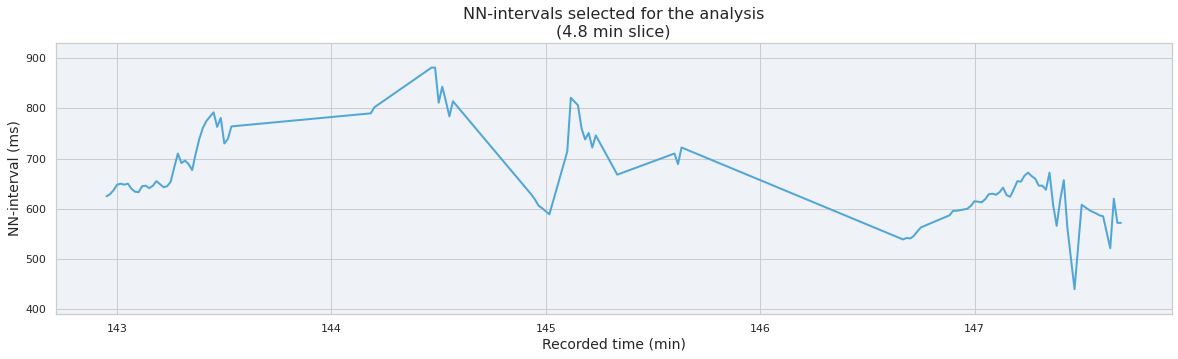

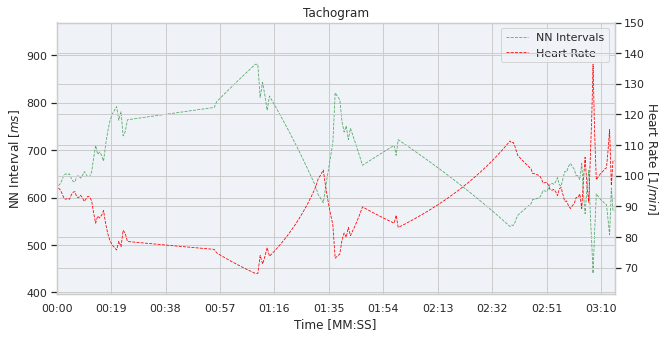

In [24]:
################## Plot section selected for the analysis ########################

# Determine if any Nan values and if so, remove them for the analysis
if nni_analysis_during.isnull().values.any() == True:
    loc = nni_analysis_during.index.get_loc(nni_analysis_during.first_valid_index()) # where the first value is located
    nni_analysis_during = nni_analysis_during[loc:] # keep only real values
    print(f'\n nni_analysis had {loc} NaN values that were removed for further analysis \n nni_analysis now has only {len(nni_analysis_during)} values', end='\n\n')
    
else:
    pass


# Determine NN interval for the analysis
nni_during = nni_analysis_during

# Plot NN intervals selected for analysis
nni_min_during = nni_during.min() - 50
nni_max_during = nni_during.max() + 50
plt.figure(figsize=(20,5))
plt.title("NN-intervals selected for the analysis\n(%.1f min slice)" % round(len(nni_during)/60,1), fontsize=16)
plt.xlabel('Recorded time (min)', fontsize=14)
plt.ylabel('NN-interval (ms)', fontsize=14)
plt.ylim(nni_min_during, nni_max_during)
plt.grid(True)

plt.plot(nni_during.index/sampling_freq, nni_during, color="#51A6D8", linewidth=2);


########################### TACHOGRAM #############################
# Plot NNi and HR on same graph
pyhrv.tools.tachogram(nni=nni_during, sampling_rate=sampling_freq, hr=True, interval=[0,len(nni_during)], title=None, figsize=(10,5));

## <span style='background :blue' > HRV Analysis </span>

<span style='color:yellow'> 
    TIME DOMAIN 
</span>

/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


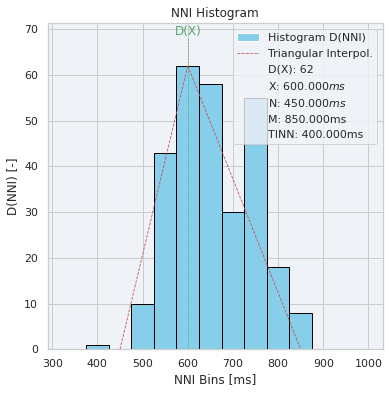


Time domain indices using NN-intervals:


/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")


- hr_mean = 89.3
- hr_std = 11.4
- hr_min = 68.1
- hr_max = 136.4
- nni_mean = 683.2
- sdnn = 86.6
- rmssd = 18.9


In [25]:
# Plot NN distribution
pyhrv.time_domain.tinn(nni=nni_during, binsize=50, plot=True, show=True, figsize=(6,6), legend=True);

# Compute Time Domain parameters using the NNI-series  
print(f"\n{bold}{red}Time domain indices using NN-intervals:{end}")
results_time_domain_during = pyhrv.time_domain.time_domain(nni=nni_during, plot=False)

params = ['hr_mean', 'hr_std', 'hr_min', 'hr_max', 'nni_mean', 'sdnn', 'rmssd']
for i in params:
    print(f'- {i} = {results_time_domain_during[i].round(1)}')

<span style='color:yellow'> 
    FREQUENCY DOMAIN 
</span>

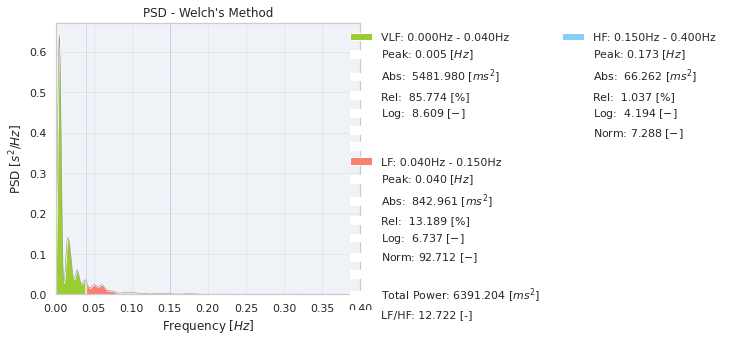


Frequency domain indice using NN-intervals:
- LF/HF ratio = 12.72


In [27]:
# Plot Frequency graph
results_welch_during = pyhrv.frequency_domain.welch_psd(nni=nni_during, window='hamming', show_param=True, legend=True);

# Print Frequency domain indice
print(f'\n{bold}{red}Frequency domain indice using NN-intervals:{end}\n- LF/HF ratio =', round(results_welch_during['fft_ratio'],2))

<span style='color:yellow'> 
    NONLINEAR DOMAIN 
</span>

In [28]:
# Plot Poincare graph -- pyHRV
results_poincare_during = pyhrv.nonlinear.poincare(nni=nni_during, show=False, figsize=(7,7), legend=True, ellipse=True, marker='o');

# Plot Poincare graph -- neurokit2
rpeaks_during = neurokit2.intervals_to_peaks(intervals=nni_during, sampling_rate=sampling_freq) #convert RR to Rpeaks
hrv_indices_during = neurokit2.hrv_nonlinear(rpeaks_during, sampling_rate=sampling_freq, show=False)


# Print Poincare indices
print(f"\n{bold}{red}Poincare incides using NN-intervals (pyHRV):{end}")  
for i, a in enumerate(results_poincare_during[1:-1]):
    param = ['SD1','SD2','SD2/SD1']  
    print(f'- {param[i]} = {round(a,1)}')

print(f"\n{bold}{red}Poincare incides using NN-intervals (neurokit2):{end}") 
print('- SD1 =', hrv_indices_during['HRV_SD1'][0].round(1))
print('- SD2 =', hrv_indices_during['HRV_SD2'][0].round(1))
print('')


Poincare incides using NN-intervals (pyHRV):
- SD1 = 13.3
- SD2 = 121.5
- SD2/SD1 = 9.1

Poincare incides using NN-intervals (neurokit2):
- SD1 = 15.1
- SD2 = 121.8



<span style='color:yellow'> 
    RADAR CHART
</span>

In [29]:
'''
# -------------------- REFERENCE INDICES --------------------

# Specify reference/baseline NN-interval
reference_nni = reference_nni


reference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)
for k, v in reference_time_domain.items():
    exec('ref_%s = %.1f' % (k,v)) # create new variable
    
reference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)
for k, v in reference_freq_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
reference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)
for k, v in reference_poincare_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
# -------------------- COMPARISON INDICES --------------------
comparison_time_domain = hrvanalysis.get_time_domain_features(nni)
for k, v in comparison_time_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)
for k, v in comparison_freq_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_poincare_domain = hrvanalysis.get_poincare_plot_features(nni)
for k, v in comparison_poincare_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
    
# -------------------- RELATIVE DIFFERENCE --------------------
ref_mean_nni_pc = ref_mean_nni / ref_mean_nni * 100
ref_sdnn_pc = ref_sdnn / ref_sdnn * 100
ref_rmssd_pc = ref_rmssd / ref_rmssd * 100
ref_sd1_pc = ref_sd1 / ref_sd1 * 100
ref_lf_hf_ratio_pc = ref_lf_hf_ratio / ref_lf_hf_ratio * 100

comp_mean_nni_pc = comp_mean_nni / ref_mean_nni * 100
comp_sdnn_pc = comp_sdnn / ref_sdnn * 100
comp_rmssd_pc = comp_rmssd / ref_rmssd * 100
comp_sd1_pc = comp_sd1 / ref_sd1 * 100
comp_lf_hf_ratio_pc = comp_lf_hf_ratio / ref_lf_hf_ratio * 100


# -------------------- GENERAL SETTINGS --------------------
# Determine indices to plot
params = ['nni_mean', 'SDNN', 'rMSSD', 'SD1', 'HF/LF ratio']

reference_nni = [ref_mean_nni_pc, ref_sdnn_pc, ref_rmssd_pc, ref_sd1_pc, ref_lf_hf_ratio_pc]
comparison_nni = [comp_mean_nni_pc, comp_sdnn_pc, comp_rmssd_pc, comp_sd1_pc, comp_lf_hf_ratio_pc]

reference_nni = [*reference_nni, reference_nni[0]]
comparison_nni = [*comparison_nni, comparison_nni[0]]

# Number of indices to plot
num_vars = len(params)


# -------------------- PLOT RADAR CHART --------------------
# Split the circle into even parts
label_loc = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()

# Complete the circle and append the start value to the end
label_loc += label_loc[:1]

# Settings
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Plot reference and comparison data
ax.plot(label_loc, reference_nni, color='turquoise', linewidth=1.5)
ax.plot(label_loc, comparison_nni, color='coral', linewidth=1.5)

# Add colour area
ax.fill(label_loc, reference_nni, color='turquoise', alpha=0.25, label='reference_nni')
ax.fill(label_loc, comparison_nni, color='coral', alpha=0.25, label='comparison_nni')

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Draw axis lines for each label location and indices
ax.set_thetagrids(np.degrees(label_loc[:-1]), params)

# Go through indices and adjust alignment based on where it is in the circle
for param, angle in zip(ax.get_xticklabels(), label_loc):
    if angle in (0, np.pi):
        param.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        param.set_horizontalalignment('left')
    else:
        param.set_horizontalalignment('right')

# Set position of y-labels (0-100) to be in the middle of the first two axes
ax.set_rlabel_position(180/num_vars)

# Make the y-axis (0-100) labels smaller
ax.tick_params(axis='y', labelsize=8)

# Change colors 
ax.tick_params(colors='#222222') #tick labels
ax.grid(color='#AAAAAA') #circular gridlines
ax.spines['polar'].set_color('#222222') #outermost gridline (the spine)
ax.set_facecolor('#FAFAFA') #background color inside the circle

# Add title
ax.set_title('\nHRV parameter Radar Chart \n Reference NNi vs. Comparison NNi \n $\it{%}$ Chart values are in %, Reference NNi parameters = 100%', size=15, y=1.15)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1));


# Save figure with participant number
plt.savefig(fname=path_file + 'analyzed//RadarChart_' + participant, format='jpeg', dpi=100, orientation='portrait', papertype='letter', transparent=True, bbox_inches='tight')


# -------------------- PRINT RESULTS --------------------
print(f"""{blue} {bold} {underline}
Parameters\tReference vs. Comparison\tDifference(%){end}
nni_mean \t{round(ref_mean_nni,2)}ms\tvs. {round(comp_mean_nni,2)}ms \t\t {round((comp_mean_nni_pc-ref_mean_nni_pc),1)} %
SDNN \t\t{round(ref_sdnn,2)}ms\tvs. {round(comp_sdnn,2)}ms \t\t {round((comp_sdnn_pc-ref_sdnn_pc),1)} %
rSSMD \t\t{round(ref_rmssd,2)}ms\tvs. {round(comp_rmssd,2)}ms \t\t {round((comp_rmssd_pc-ref_rmssd_pc),1)} %
SD1 \t\t{round(ref_sd1,2)}\tvs. {round(comp_sd1,2)} \t\t {round((comp_sd1_pc-ref_sd1_pc),1)} %
HF/LF ratio \t{round(ref_lf_hf_ratio,2)}\tvs. {round(comp_lf_hf_ratio,2)} \t\t {round((comp_lf_hf_ratio_pc-ref_lf_hf_ratio_pc),1)} %
""")

'''

'\n# -------------------- REFERENCE INDICES --------------------\n\n# Specify reference/baseline NN-interval\nreference_nni = reference_nni\n\n\nreference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)\nfor k, v in reference_time_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v)) # create new variable\n    \nreference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)\nfor k, v in reference_freq_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \nreference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)\nfor k, v in reference_poincare_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \n# -------------------- COMPARISON INDICES --------------------\ncomparison_time_domain = hrvanalysis.get_time_domain_features(nni)\nfor k, v in comparison_time_domain.items():\n    exec(\'comp_%s = %.1f\' % (k,v))\n    \ncomparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)\nfor k, v in comparison_freq_doma

## <span style='background :blue' > Report - DURING </span>

In [30]:
results_during = []
metrics_during = {}


metrics_during['mean_HR (bpm)'] = round(results_time_domain_during['hr_mean'])
metrics_during['SD_HR (bpm)'] = round(results_time_domain_during['hr_std'])
metrics_during['min_HR (bpm)'] = round(results_time_domain_during['hr_min'])
metrics_during['max_HR (bpm)'] = round(results_time_domain_during['hr_max'])
metrics_during['mean_nni (ms)'] = round(results_time_domain_during['nni_mean'])
metrics_during['SDNN (ms)'] = results_time_domain_during['sdnn'].round(1)
metrics_during['rMSSD (ms)'] = results_time_domain_during['rmssd'].round(1)
metrics_during['LF/HF ratio'] = results_welch_during['fft_ratio'].round(3)
metrics_during['SD1 (ms)'] = results_poincare_during['sd1'].round(1)
metrics_during['SD2 (ms)'] = results_poincare_during['sd2'].round(1)
metrics_during['SD2/SD1 ratio'] = results_poincare_during['sd_ratio'].round(3)
metrics_during['SI'] = round(SI_during)
metrics_during['correction (%)'] = round(corrected_during, 1)
metrics_during['HR Conf (%)'] = round(merged_df.HRConfidence[start_index_during:stop_index_during].mean(),1)
metrics_during['N_beats'] = len(nni_analysis_during)


results_during.append(metrics_during)


# If participant is the first and Event=Reference, create DF to store results
if (participant == first_participant) and (first_event == event):
    results_hrv_df = pd.DataFrame(results_during)
    results_hrv_df.insert(loc=0, column='Participant', value=participant)    
    results_hrv_df.insert(loc=results_hrv_df.shape[1], column='Date', value=merged_df.Date[start_index_during])
    results_hrv_df.insert(loc=results_hrv_df.shape[1], column='Event', value=event)
    results_hrv_df.insert(loc=results_hrv_df.shape[1], column='When', value='Sitting')

# If not, read DF
else:
    results_hrv_df = pd.read_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', sheet_name=0, skiprows=0, header=0, index_col=0)


# If participant is the first and Event=Reference, create new directories if not exists
if (participant == first_participant) and (first_event == event):
    os.makedirs(path_file + 'results_HRV/', exist_ok=True)

# If not, append the results to existing DF
else:
    results_hrv_df = results_hrv_df.append(results_during, ignore_index=True)
    results_hrv_df.iat[len(results_hrv_df.index)-1,0] = participant
    results_hrv_df.iat[len(results_hrv_df.index)-1,-3] = merged_df.Date[start_index_during]
    results_hrv_df.iat[len(results_hrv_df.index)-1,-2] = event
    results_hrv_df.iat[len(results_hrv_df.index)-1,-1] = prefix_during


# Conditional formatting
def highlight_cells_correction(val):
    color = 'red' if val >= 5.0 else None
    return 'background-color: {}'.format(color)

def highlight_cells_hrconfidence(val):
    condition1 = (val < 50) & (val > 20)
    condition2 = val <= 20
    font_color = 'red' if condition1 else None
    background_color = 'red' if condition2 else None
    return 'color: {}; background-color: {}'.format(font_color, background_color)

# Display DF
results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])


# results_hrv_df.style.format(formatter={"SDNN (ms)": "{:.1f}", "rMSSD (ms)": "{:.1f}", "LF/HF ratio": "{:.2f}", "SD1 (ms)": "{:.1f}", "SD2 (ms)": "{:.1f}",\
#                                        "SD2/SD1 ratio": "{:.3f}", "correction (%)": "{:.1f}", "HR Conf (%)": "{:.1f}"})

In [31]:
results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])\
                    .to_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', engine='openpyxl', index=True)

/home/sylvie/anaconda3/lib/python3.8/site-packages/pandas/io/formats/excel.py:331: CSSWarning: Unhandled color format: 'none'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)


# <span style='background :green' > Analysis --> POST </span>

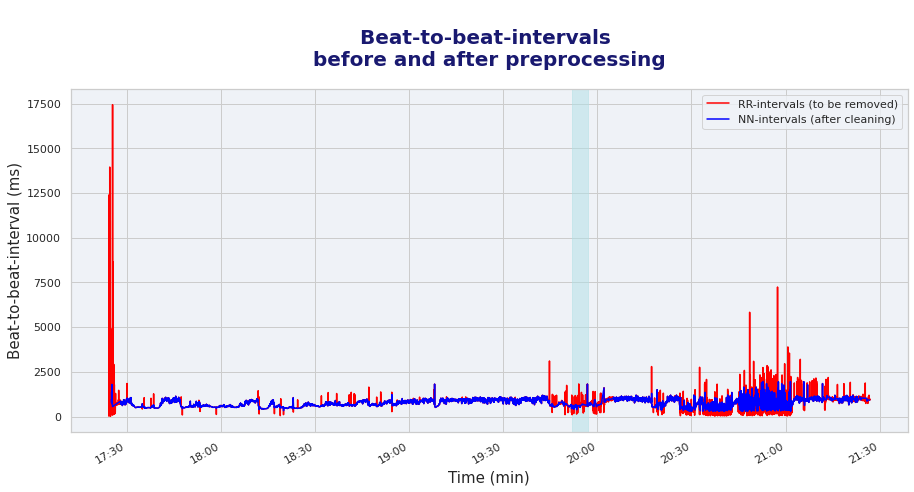

In [32]:
# ----------------- GENERAL SETTINGS -----------------

if first_event == event:
    delta_pd_post = pd.to_timedelta(duration_analysis_general, unit='m')
    
    start_time_pd = pd.to_datetime(start_time_str, format='%H:%M:%S')
    start_time_pd_post = (start_time_pd + delta_pd_post).round(freq='S')
    start_time_post = start_time_pd_post.time()
    
    stop_time_pd_post = (start_time_pd_post + delta_pd_post).round(freq='S')
    stop_time_post = stop_time_pd_post.time()
    start_index_post = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == start_time_post][0]
    stop_index_post = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == stop_time_post][0]
    
else:    
    delta_pd_post = pd.to_timedelta(duration_analysis_general, unit='m')
    stop_time_task_pd = pd.to_datetime(stop_time_str, format='%H:%M:%S')
    stop_time_pd_post = (stop_time_task_pd + delta_pd_post).round(freq='S')
    start_time_post = stop_time_task_pd.time()
    stop_time_post = stop_time_pd_post.time()
    start_index_post = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == start_time_post][0]
    stop_index_post = [i for i in range(len(merged_df.Time)) if merged_df.Time[i] == stop_time_post][0]




# ----------------- PLOT RR/NN INTERVALS -----------------

# Plot raw and cleaned signals
fig, ax = plt.subplots(figsize=(15, 7))

plt.title("\nBeat-to-beat-intervals \nbefore and after preprocessing", fontsize=20, weight='bold', ha='center', y=1.05, color='midnightblue')         
plt.xlabel("Time (min)", fontsize=15)
plt.ylabel("Beat-to-beat-interval (ms)", fontsize=15)

plt.plot(merged_df.DateTime, merged_df.RtoR, color="red", label="RR-intervals (to be removed)")
plt.plot(merged_df.DateTime, nni_total, color="blue", label="NN-intervals (after cleaning)")


# Change X-axis to Time format
plt.gcf().autofmt_xdate()
time_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_format)

# Shaded area
year = merged_df['DateTime'].dt.year[start_index_post].astype(int)
month = merged_df['DateTime'].dt.month[start_index_post].astype(int)
day = merged_df['DateTime'].dt.day[start_index_post].astype(int)
start_hour = merged_df['DateTime'].dt.hour[start_index_post].astype(int)
start_minute = merged_df['DateTime'].dt.minute[start_index_post].astype(int)
stop_hour = merged_df['DateTime'].dt.hour[stop_index_post].astype(int)
stop_minute = merged_df['DateTime'].dt.minute[stop_index_post].astype(int)

ax.axvspan(mdates.date2num(datetime(year,month,day,start_hour,start_minute)), mdates.date2num(datetime(year,month,day,stop_hour,stop_minute)), 0, 1, alpha=0.5, color='powderblue')

# Add legend
plt.legend(loc='best');

## <span style='background :blue' > Cleaning - selection only</span>
Pre-processing for the outliers and ectopic beats. <br>
Interpolate outliers and ectopic beats with linear interpolation <br>
Determine % correction of the chosen HRV analysis section

In [33]:
# Replace RR-interval outlier by nan
rr_no_outliers_post = hrvanalysis.remove_outliers(rr_intervals=merged_df.RtoR_gt20[start_index_post:stop_index_post], low_rri=300, high_rri=2000, verbose=True)

# Replace nan values with linear interpolation
rr_interpolated_post = hrvanalysis.interpolate_nan_values(rr_intervals=rr_no_outliers_post, interpolation_method="linear")

# Remove ectopic beats from signal (method: malik, karlsson, kamath, acar)
nni_no_ectopic_post = hrvanalysis.remove_ectopic_beats(rr_intervals=rr_interpolated_post, method="malik", custom_removing_rule=10, verbose=True)

# Replace ectopic beats (nan values) with linear interpolation
nni_interpolated_post = hrvanalysis.interpolate_nan_values(rr_intervals=nni_no_ectopic_post, interpolation_method="linear")

# Convert NN to Series with same index as rr_raw
new_index_analysis_post = list(np.arange(start=merged_df.RtoR_gt20[start_index_post:stop_index_post].index.start, \
                                     stop=merged_df.RtoR_gt20[start_index_post:stop_index_post].index.stop, step=1)) 

# Determine cleaned NN-intervals (>20%)
nni_analysis_post = pd.Series(nni_interpolated_post, index=new_index_analysis_post, name='nni_post')

# Calculate % corrected
n_outlier_post = sum(math.isnan(x) for x in rr_no_outliers_post)
n_ectopic_post = sum(math.isnan(x) for x in nni_no_ectopic_post)
corrected_post = (n_outlier_post+n_ectopic_post)/(2*len(nni_analysis_post))*100

print(f"""
{underline}{bold}Findings - Analysis Section{end}
{n_outlier_post} outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
{n_ectopic_post} ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

{underline}{bold}{blue}Discussion - Analysis Section{end}
A total of {n_outlier_post+n_ectopic_post} beat(s) were interpolated using the linear method which is equivalent to {blue}{red}{round(corrected_post,2)}%{end} of all beats selected for the analysis.
The recommended percentage of artifact correction is less than 5% so this section of the signal ({bold}nni_analysis{end}) can be used to calculate HRV indices.
""")

165 outlier(s) have been deleted.
The outlier(s) value(s) are : [170, 141, 232, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11 ectopic beat(s) have been deleted with malik rule.

Findings - Analysis Section
165 outliers were found in the raw signal choosen for analysis and were interpolated linearly, if applicable
11 ectopic beats were found in the interpolated RR-interval signal chosen for analysis and were also corrected using linear interpolation, if applicable

Discussion - Analysis Section
A total of 176 beat(s) were interpolated using the linear 

/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/tools.py:375: UserWarning: Interval limits out of boundaries. Interval set to: [0, 186.89116666666666]
  interval = pyhrv.utils.check_interval(interval, limits=[0, t[-1]], default=[0, 10])


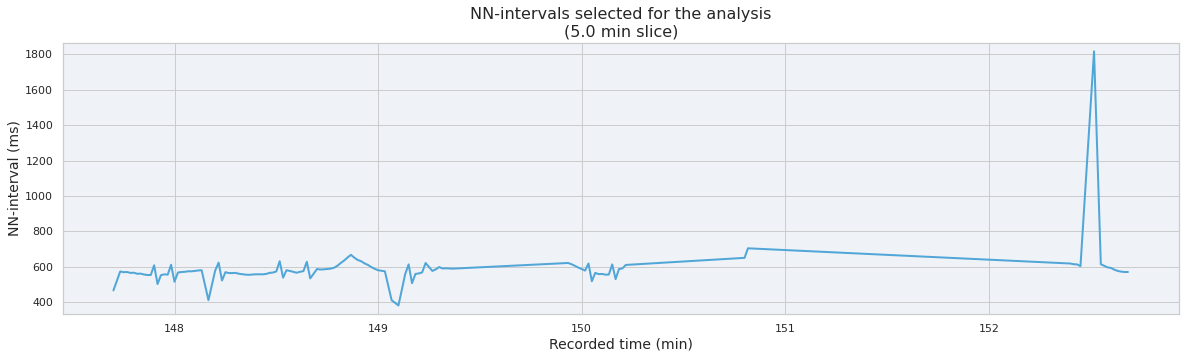

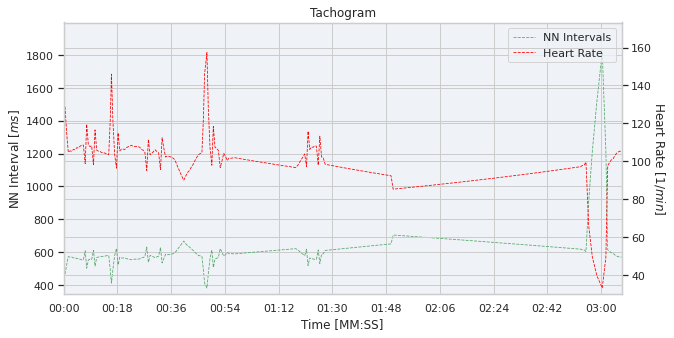

In [34]:
################## Plot section selected for the analysis ########################


# Determine if any Nan values and if so, remove them for the analysis
if nni_analysis_post.isnull().values.any() == True:
    loc = nni_analysis_post.index.get_loc(nni_analysis_post.first_valid_index()) # where the first value is located
    nni_analysis_post = nni_analysis_post[loc:] # keep only real values
    print(f'\n nni_analysis had {loc} NaN values that were removed for further analysis \n nni_analysis now has only {len(nni_analysis_post)} values', end='\n\n')
    
else:
    pass


# Determine NN interval for the analysis
nni_post = nni_analysis_post

# Plot NN intervals selected for analysis
nni_min_post = nni_post.min() - 50
nni_max_post = nni_post.max() + 50
plt.figure(figsize=(20,5))
plt.title("NN-intervals selected for the analysis\n(%.1f min slice)" % round(len(nni_post)/60,1), fontsize=16)
plt.xlabel('Recorded time (min)', fontsize=14)
plt.ylabel('NN-interval (ms)', fontsize=14)
plt.ylim(nni_min_post, nni_max_post)
plt.grid(True)

plt.plot(nni_post.index/sampling_freq, nni_post, color="#51A6D8", linewidth=2);


########################### TACHOGRAM #############################
# Plot NNi and HR on same graph
pyhrv.tools.tachogram(nni=nni_post, sampling_rate=sampling_freq, hr=True, interval=[0,len(nni_post)], title=None, figsize=(10,5));

## <span style='background :blue' > HRV Analysis </span>

<span style='color:yellow'> 
    TIME DOMAIN 
</span>

/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


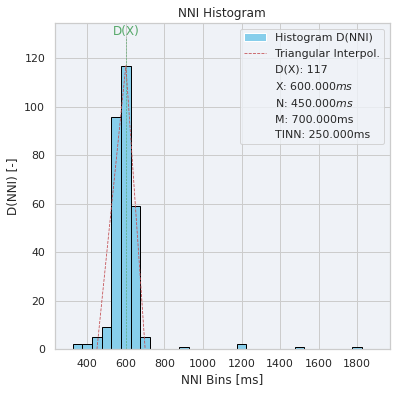


Time domain indices using NN-intervals:


/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
/home/sylvie/anaconda3/lib/python3.8/site-packages/pyhrv/time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")


- hr_mean = 98.2
- hr_std = 11.8
- hr_min = 33.0
- hr_max = 157.5
- nni_mean = 623.0
- sdnn = 113.5
- rmssd = 65.5


In [35]:
# Plot NN distribution
pyhrv.time_domain.tinn(nni=nni_post, binsize=50, plot=True, show=True, figsize=(6,6), legend=True);

# Compute Time Domain parameters using the NNI-series  
print(f"\n{bold}{red}Time domain indices using NN-intervals:{end}")
results_time_domain_post = pyhrv.time_domain.time_domain(nni=nni_post, plot=False)

params = ['hr_mean', 'hr_std', 'hr_min', 'hr_max', 'nni_mean', 'sdnn', 'rmssd']
for i in params:
    print(f'- {i} = {results_time_domain_post[i].round(1)}')

Baevsky’s Stress Index SI: 24
Baevsky’s Stress Index SI_2: 79


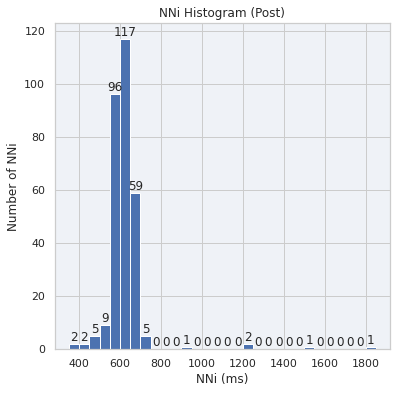

In [62]:
# Plot histogram
nni = nni_post
nni_min = nni.min()
nni_max = nni.max()
binsize = 50 # 50ms bin width
bins = np.arange(round((nni_min-50)/50)*50, nni_max + binsize, binsize)


plt.figure(figsize=(6,6))
counts, edges, bars = plt.hist(x=nni, bins=bins, facecolor='b', orientation='vertical', histtype='bar', stacked=False)
plt.bar_label(bars) # counts on top
plt.title('NNi Histogram (Post)')
plt.xlabel('NNi (ms)')
plt.ylabel('Number of NNi')
plt.xlim(nni_min-100, nni_max+100);


############################### Baevsky’s Stress Index

# AMo was calculated, using a 50 ms bin width, as the number of the RR intervals in the bin containing the Mo, expressed as a percentage of the total number of intervals measured.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8275990/
# https://pdfs.semanticscholar.org/f9aa/e61bb8301565683a63592ed57e47765b6671.pdf?_ga=2.243993989.1087171154.1670987388-1864625205.1670987388
# https://www.academia.edu/35296847/Methodical_recommendations_USE_KARDiVAR_SYSTEM_FOR_DETERMINATION_OF_THE_STRESS_LEVEL_AND_ESTIMATION_OF_THE_BODY_ADAPTABILITY_Standards_of_measurements_and_physiological_interpretation_Moscow_Prague_2008
Mo = stats.mode(nni)[0][0]/1000 # sec
MxDMn = (nni_max-nni_min)/1000 # sec
N = len(nni)
AMo = counts.max()/N # number of intervals in the taller bin (where the Mo should lie?)

SI = AMo*100 / (2*Mo*MxDMn)
SI_2 = AMo*100 / (2*Mo*3.92*results_time_domain_post['sdnn']/1000) # https://arxiv.org/pdf/2210.01791.pdf
# this corresponds to the range spanning 95% of interval samples within the set (i.e. 1.96 standard deviations in either direction of the mean). 
# This was experimentally observed to provide readings more robust to noise that arises from the misclassification of a single inter-beat interval
print('Baevsky’s Stress Index SI:', round(SI))
print('Baevsky’s Stress Index SI_2:', round(SI_2))

<span style='color:yellow'> 
    FREQUENCY DOMAIN 
</span>

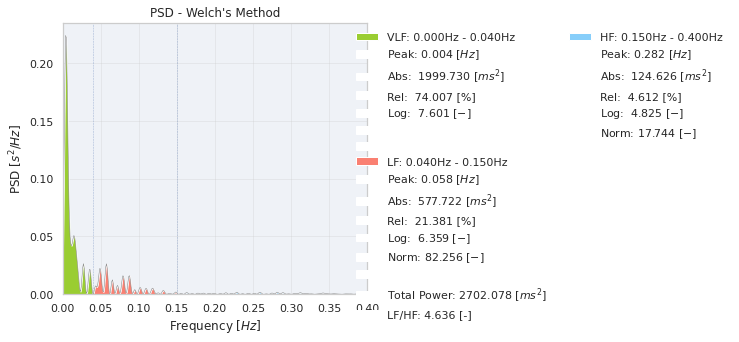


Frequency domain indice using NN-intervals:
- LF/HF ratio = 4.64


In [37]:
# Plot Frequency graph
results_welch_post = pyhrv.frequency_domain.welch_psd(nni=nni_post, window='hamming', show_param=True, legend=True);

# Print Frequency domain indice
print(f'\n{bold}{red}Frequency domain indice using NN-intervals:{end}\n- LF/HF ratio =', round(results_welch_post['fft_ratio'],2))

<span style='color:yellow'> 
    NONLINEAR DOMAIN 
</span>

In [38]:
# Plot Poincare graph -- pyHRV
results_poincare_post = pyhrv.nonlinear.poincare(nni=nni_post, show=False, figsize=(7,7), legend=True, ellipse=True, marker='o');

# Plot Poincare graph -- neurokit2
rpeaks_post = neurokit2.intervals_to_peaks(intervals=nni_post, sampling_rate=sampling_freq) #convert RR to Rpeaks
hrv_indices_post = neurokit2.hrv_nonlinear(rpeaks_post, sampling_rate=sampling_freq, show=False)


# Print Poincare indices
print(f"\n{bold}{red}Poincare incides using NN-intervals (pyHRV):{end}")  
for i, a in enumerate(results_poincare_post[1:-1]):
    param = ['SD1','SD2','SD2/SD1']  
    print(f'- {param[i]} = {round(a,1)}')

print(f"\n{bold}{red}Poincare incides using NN-intervals (neurokit2):{end}") 
print('- SD1 =', hrv_indices_post['HRV_SD1'][0].round(1))
print('- SD2 =', hrv_indices_post['HRV_SD2'][0].round(1))
print('')


Poincare incides using NN-intervals (pyHRV):
- SD1 = 46.3
- SD2 = 153.4
- SD2/SD1 = 3.3

Poincare incides using NN-intervals (neurokit2):
- SD1 = 47.0
- SD2 = 153.9



<span style='color:yellow'> 
    RADAR CHART
</span>

In [39]:
'''
# -------------------- REFERENCE INDICES --------------------

# Specify reference/baseline NN-interval
reference_nni = reference_nni


reference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)
for k, v in reference_time_domain.items():
    exec('ref_%s = %.1f' % (k,v)) # create new variable
    
reference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)
for k, v in reference_freq_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
reference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)
for k, v in reference_poincare_domain.items():
    exec('ref_%s = %.1f' % (k,v))
    
# -------------------- COMPARISON INDICES --------------------
comparison_time_domain = hrvanalysis.get_time_domain_features(nni)
for k, v in comparison_time_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)
for k, v in comparison_freq_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
comparison_poincare_domain = hrvanalysis.get_poincare_plot_features(nni)
for k, v in comparison_poincare_domain.items():
    exec('comp_%s = %.1f' % (k,v))
    
    
# -------------------- RELATIVE DIFFERENCE --------------------
ref_mean_nni_pc = ref_mean_nni / ref_mean_nni * 100
ref_sdnn_pc = ref_sdnn / ref_sdnn * 100
ref_rmssd_pc = ref_rmssd / ref_rmssd * 100
ref_sd1_pc = ref_sd1 / ref_sd1 * 100
ref_lf_hf_ratio_pc = ref_lf_hf_ratio / ref_lf_hf_ratio * 100

comp_mean_nni_pc = comp_mean_nni / ref_mean_nni * 100
comp_sdnn_pc = comp_sdnn / ref_sdnn * 100
comp_rmssd_pc = comp_rmssd / ref_rmssd * 100
comp_sd1_pc = comp_sd1 / ref_sd1 * 100
comp_lf_hf_ratio_pc = comp_lf_hf_ratio / ref_lf_hf_ratio * 100


# -------------------- GENERAL SETTINGS --------------------
# Determine indices to plot
params = ['nni_mean', 'SDNN', 'rMSSD', 'SD1', 'HF/LF ratio']

reference_nni = [ref_mean_nni_pc, ref_sdnn_pc, ref_rmssd_pc, ref_sd1_pc, ref_lf_hf_ratio_pc]
comparison_nni = [comp_mean_nni_pc, comp_sdnn_pc, comp_rmssd_pc, comp_sd1_pc, comp_lf_hf_ratio_pc]

reference_nni = [*reference_nni, reference_nni[0]]
comparison_nni = [*comparison_nni, comparison_nni[0]]

# Number of indices to plot
num_vars = len(params)


# -------------------- PLOT RADAR CHART --------------------
# Split the circle into even parts
label_loc = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()

# Complete the circle and append the start value to the end
label_loc += label_loc[:1]

# Settings
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Plot reference and comparison data
ax.plot(label_loc, reference_nni, color='turquoise', linewidth=1.5)
ax.plot(label_loc, comparison_nni, color='coral', linewidth=1.5)

# Add colour area
ax.fill(label_loc, reference_nni, color='turquoise', alpha=0.25, label='reference_nni')
ax.fill(label_loc, comparison_nni, color='coral', alpha=0.25, label='comparison_nni')

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Draw axis lines for each label location and indices
ax.set_thetagrids(np.degrees(label_loc[:-1]), params)

# Go through indices and adjust alignment based on where it is in the circle
for param, angle in zip(ax.get_xticklabels(), label_loc):
    if angle in (0, np.pi):
        param.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        param.set_horizontalalignment('left')
    else:
        param.set_horizontalalignment('right')

# Set position of y-labels (0-100) to be in the middle of the first two axes
ax.set_rlabel_position(180/num_vars)

# Make the y-axis (0-100) labels smaller
ax.tick_params(axis='y', labelsize=8)

# Change colors 
ax.tick_params(colors='#222222') #tick labels
ax.grid(color='#AAAAAA') #circular gridlines
ax.spines['polar'].set_color('#222222') #outermost gridline (the spine)
ax.set_facecolor('#FAFAFA') #background color inside the circle

# Add title
ax.set_title('\nHRV parameter Radar Chart \n Reference NNi vs. Comparison NNi \n $\it{%}$ Chart values are in %, Reference NNi parameters = 100%', size=15, y=1.15)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1));


# Save figure with participant number
plt.savefig(fname=path_file + 'analyzed//RadarChart_' + participant, format='jpeg', dpi=100, orientation='portrait', papertype='letter', transparent=True, bbox_inches='tight')


# -------------------- PRINT RESULTS --------------------
print(f"""{blue} {bold} {underline}
Parameters\tReference vs. Comparison\tDifference(%){end}
nni_mean \t{round(ref_mean_nni,2)}ms\tvs. {round(comp_mean_nni,2)}ms \t\t {round((comp_mean_nni_pc-ref_mean_nni_pc),1)} %
SDNN \t\t{round(ref_sdnn,2)}ms\tvs. {round(comp_sdnn,2)}ms \t\t {round((comp_sdnn_pc-ref_sdnn_pc),1)} %
rSSMD \t\t{round(ref_rmssd,2)}ms\tvs. {round(comp_rmssd,2)}ms \t\t {round((comp_rmssd_pc-ref_rmssd_pc),1)} %
SD1 \t\t{round(ref_sd1,2)}\tvs. {round(comp_sd1,2)} \t\t {round((comp_sd1_pc-ref_sd1_pc),1)} %
HF/LF ratio \t{round(ref_lf_hf_ratio,2)}\tvs. {round(comp_lf_hf_ratio,2)} \t\t {round((comp_lf_hf_ratio_pc-ref_lf_hf_ratio_pc),1)} %
""")

'''

'\n# -------------------- REFERENCE INDICES --------------------\n\n# Specify reference/baseline NN-interval\nreference_nni = reference_nni\n\n\nreference_time_domain = hrvanalysis.get_time_domain_features(reference_nni)\nfor k, v in reference_time_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v)) # create new variable\n    \nreference_freq_domain = hrvanalysis.get_frequency_domain_features(reference_nni)\nfor k, v in reference_freq_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \nreference_poincare_domain = hrvanalysis.get_poincare_plot_features(reference_nni)\nfor k, v in reference_poincare_domain.items():\n    exec(\'ref_%s = %.1f\' % (k,v))\n    \n# -------------------- COMPARISON INDICES --------------------\ncomparison_time_domain = hrvanalysis.get_time_domain_features(nni)\nfor k, v in comparison_time_domain.items():\n    exec(\'comp_%s = %.1f\' % (k,v))\n    \ncomparison_freq_domain = hrvanalysis.get_frequency_domain_features(nni)\nfor k, v in comparison_freq_doma

## <span style='background :blue' > Report - POST </span>

In [40]:
# Note: only create a DF if the Event is not Reference (because we don't need Post- for Reference)
if first_event == event:
    pass
else:

    results_post = []
    metrics_post = {}


    metrics_post['mean_HR (bpm)'] = round(results_time_domain_post['hr_mean'])
    metrics_post['SD_HR (bpm)'] = round(results_time_domain_post['hr_std'])
    metrics_post['min_HR (bpm)'] = round(results_time_domain_post['hr_min'])
    metrics_post['max_HR (bpm)'] = round(results_time_domain_post['hr_max'])
    metrics_post['mean_nni (ms)'] = round(results_time_domain_post['nni_mean'])
    metrics_post['SDNN (ms)'] = results_time_domain_post['sdnn'].round(1)
    metrics_post['rMSSD (ms)'] = results_time_domain_post['rmssd'].round(1)
    metrics_post['LF/HF ratio'] = results_welch_post['fft_ratio'].round(3)
    metrics_post['SD1 (ms)'] = results_poincare_post['sd1'].round(1)
    metrics_post['SD2 (ms)'] = results_poincare_post['sd2'].round(1)
    metrics_post['SD2/SD1 ratio'] = results_poincare_post['sd_ratio'].round(3)
    metrics_post['SI'] = round(SI_post)
    metrics_post['correction (%)'] = round(corrected_post, 1)
    metrics_post['HR Conf (%)'] = round(merged_df.HRConfidence[start_index_post:stop_index_post].mean(),1)
    metrics_post['N_beats'] = len(nni_analysis_post)


    results_post.append(metrics_post)

    # Read DF
    results_hrv_df = pd.read_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', sheet_name=0, skiprows=0, header=0, index_col=0)

    # Save/Append results to DF

    results_hrv_df = results_hrv_df.append(results_post, ignore_index=True)
    results_hrv_df.iat[len(results_hrv_df.index)-1,0] = participant
    results_hrv_df.iat[len(results_hrv_df.index)-1,-3] = merged_df.Date[start_index_post]
    results_hrv_df.iat[len(results_hrv_df.index)-1,-2] = event
    results_hrv_df.iat[len(results_hrv_df.index)-1,-1] = prefix_post


# Format DF
def highlight_cells_correction(val):
    color = 'red' if val >= 5.0 else None
    return 'background-color: {}'.format(color)

def highlight_cells_hrconfidence(val):
    condition1 = (val < 50) & (val > 20)
    condition2 = val <= 20
    font_color = 'red' if condition1 else None
    background_color = 'red' if condition2 else None
    return 'color: {}; background-color: {}'.format(font_color, background_color)

results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])

# results_hrv_df.style.format(formatter={"SDNN (ms)": "{:.1f}", "rMSSD (ms)": "{:.1f}", "LF/HF ratio": "{:.2f}", "SD1 (ms)": "{:.1f}", "SD2 (ms)": "{:.1f}",\
#                                        "SD2/SD1 ratio": "{:.3f}", "correction (%)": "{:.1f}", "HR Conf (%)": "{:.1f}"})

In [41]:
# Only save if Event is not Reference (because we don't need Post- for Reference)
if first_event == event:
    pass
else:
    results_hrv_df.style.applymap(highlight_cells_correction, subset=['correction (%)'])\
                    .applymap(highlight_cells_hrconfidence, subset=['HR Conf (%)'])\
                    .to_excel(path_file + 'results_HRV/' + event + '_results_HRV_df.xlsx', engine='openpyxl', index=True)

/home/sylvie/anaconda3/lib/python3.8/site-packages/pandas/io/formats/excel.py:331: CSSWarning: Unhandled color format: 'none'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)
